 2) Design a combinatorial bandit algorithm to optimize the budget allocation over the three subcampaigns
  to maximize the total number of clicks. Plot the cumulative regret.
prima si stimano le curve (budget allocato -> numero di click + rumore gaussiano)\n",
poi crea la tabella e si trova la combinazione migliore di sub per avere il massimo numero di click\n",


    CURVE\n",
    MAX_BUDGET * (1.0 - np.exp(-(PARAMETRO_SUB * x))\n",

    RUMORE: generazione sample con rumore\n",
    SAMPLE = np.random.normal(CLICK_Y_CURVA, VARIANZA_FISSA)\n",
    CLICK_Y_CURVA = valore del numero di click preso dalla curva dato un budget x\n",

   Dai vari SAMPLE si generano le  3 CURVA_GEN con un GP\n",

    Dalle curve si riempie la prima tabella con i valori di budget prefissati:
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    Si applica l'optimization problem per decidere la combinazione migliore di subcampaign

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner

In [2]:
n_obs = 50
x_obs = np.ndarray(shape=(0,3), dtype=float)
print(x_obs.shape)
y_obs = np.ndarray(shape=(0,3), dtype=float)
print(y_obs.shape)

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 6.0

bids = np.linspace(0, max_bid, n_arms)
print(bids)

env = BiddingEnvironment(bids,max_clicks,noise_std)
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

(0, 3)
(0, 3)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
for i in range(0, n_obs):
    clicks = []
    pulled = [l.pull_arm() for l in learners]


    clicks = env.round(pulled[0],pulled[1],pulled[2])
    for x in range(0,len(learners)):
        learners[x].update(pulled[x], clicks[x])
    y_obs = np.append(y_obs,np.atleast_2d(clicks),0)
    x_obs = np.append(x_obs,np.atleast_2d(bids[pulled]),0)

print(y_obs.shape)
print(x_obs.shape)

(50, 3)
(50, 3)


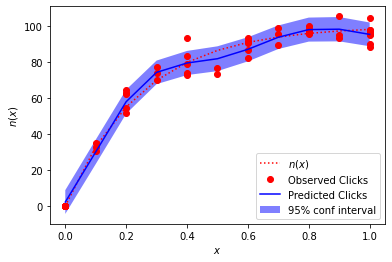

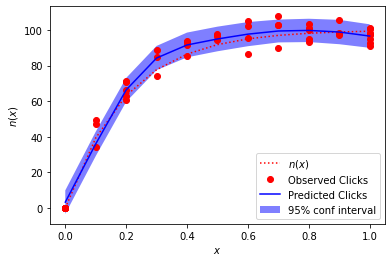

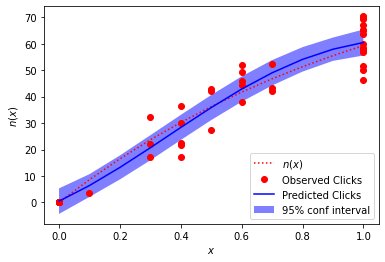

In [4]:
x_pred = np.atleast_2d(bids).T

for i in range(0,len(learners)):

    X = np.atleast_2d(x_obs[:,i]).T
    Y = y_obs[:,i].ravel()

    plt.figure()

    plt.plot(x_pred, env.subs[i](x_pred), 'r:', label=r'$n(x)$')
    plt.plot(X.ravel(), Y, 'ro', label=r'Observed Clicks')
    plt.plot(x_pred, learners[i].means, 'b-', label=r'Predicted Clicks')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([learners[i].means - 1.96 * learners[i].sigmas, (learners[i].means + 1.96 * learners[i].sigmas)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% conf interval')
    plt.xlabel('$x$')
    plt.ylabel('$n(x)$')
    plt.legend(loc='lower right')
    plt.show()

Ora va sviluppato l'algoritmo della tabella
per prendera l'alloacazione migliore

budget1 + budget2 + budget3 = 1

In [5]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)

[[ 2.16337897 30.03513241 57.94466296 74.27934619 79.46680613 81.8522203
  87.08341918 93.80104397 98.04775547 98.26632878 95.39361553]
 [ 3.26536577 35.98822633 66.3455936  84.25372491 91.58888701 94.95630047
  97.66957582 99.44021595 99.76697697 98.85963794 96.593694  ]
 [ 0.46113669  6.37283814 13.22023929 20.67108482 28.35024648 35.87127165
  42.86868443 49.02727213 54.10510766 57.94803536 60.49459849]]


In [ ]:
ALGORITMO DELLA TABELLA:

In [6]:
algorithm_table = np.ndarray(shape=(0,len(bids)), dtype=float)

for l in learners:
   algorithm_table = np.append(algorithm_table,np.atleast_2d(np.zeros(len(bids))),0)

algorithm_table[0,:] = table_all_Subs[0,:]

allocations_table = [[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]]


for i in range(1, n_subcamp):
    allocations_table.append([[],[],[],[],[],[],[],[],[],[],[]])

    for j in range(0, len(bids)):
        possibilities = np.array([])
        poss_allocation = []
        for p in range(0,j+1):
            #if bids[p] + bids[j-p] <= bids[j] :
            possibilities = np.append(possibilities, table_all_Subs[i,p]+algorithm_table[i-1,j-p])
            poss_allocation.append(allocations_table[i-1][j-p] + [p])
            #print(str(i)+" "+ str(p) + " "+ str(j-p))

        max_index = np.argmax(possibilities)
        #print(poss_allocation)
        #print(possibilities)

        #print(max_index)
        algorithm_table[i,j] = possibilities[max_index]
        allocations_table[i][j] = poss_allocation[max_index]

print(allocations_table[n_subcamp-1])
print(max(algorithm_table[n_subcamp-1]))



[[0, 0, 0], [0, 1, 0], [0, 2, 0], [1, 2, 0], [2, 2, 0], [2, 3, 0], [3, 3, 0], [3, 4, 0], [3, 4, 1], [3, 3, 3], [3, 3, 4]]
186.88331758271502
